Chapter 6: Explaining the challenge task
Suggested: Theo, everyone
- Show the mitotic cells (n) in the dataset, explain how we got to these mitotic labels (manual annotation and machine prediction)
- Link to integrated mitotic cell on allencell.org
- Explain how we do the train, test, validation, split (perhaps this should be a column in the manifest, or that can be pulled into the manifest)
- Train a simple model to predict mitotic stage based on metrics (random forests)
- Explaining the task
- Can you build a more advanced classifier, one with the lowest possible error on the test set?
- Are there mislabeled cells in the dataset, i.e. those that are systematically mispredicted?
- Which features (metrics and image channels) boost classification performance?
- Does it help to use 3D images vs 2D images?
- Can you report on biological observations / insights based on this task?



# 6 Explaining the challenge task
**Estimated time to run through notebook is 20 minutes** 

This notebook shows how to
-  [Load libraries, predefine some functions, and load the manifest](#preprocessing)
-  [4.1 Visualize cell metrics in various ways](#visualize)
-  [4.2 Perform statistical analyses on these metric data](#stats)
-  [Conclusion](#end)

We explore the dataset's metrics by focusing on two aspects of the cells in the dataset:
1. In 4.1 we look at mitotic vs. interphase cells
2. In 4.2 we look at edge vs non-edge cells

#### Resources
- pandas for reading and slicing manifests - https://pandas.pydata.org
- matlpotlib for plotting - https://matplotlib.org
- sklearn for statistical analysis - https://scikit-learn.org/


## <a id='preprocessing'></a>Load libraries, predefine some functions, and load the manifest 

### Load libraries and predefined functions

In [20]:
# First "pip install -e ." from command line (when in cytodata-hackathon-base)

import logging
logging.getLogger("bfio").setLevel(logging.ERROR)
logging.getLogger("bfio.backends").setLevel(logging.ERROR)
logging.getLogger("aicsimageio").setLevel(logging.ERROR)

from upath import UPath as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv
import warnings
from aicsimageio import transforms, AICSImage
from aicsimageprocessing import diagnostic_sheet, read_ome_zarr, rescale_image, imgtoprojection

from serotiny.io.image import image_loader
from cytodata_aics.io_utils import rescale_image

### Load the manifest and explore dimensions

In [3]:
df = pd.read_parquet("s3://allencell-cytodata-variance-data/variance-dataset/processed/hackathon_manifest_092022.parquet")
print(f'Number of cells: {len(df)}')
print(f'Number of columns: {len(df.columns)}')

Number of cells: 214037
Number of columns: 78


## <a id='visualize'></a> 6.1 Mitotic cells in the dataset

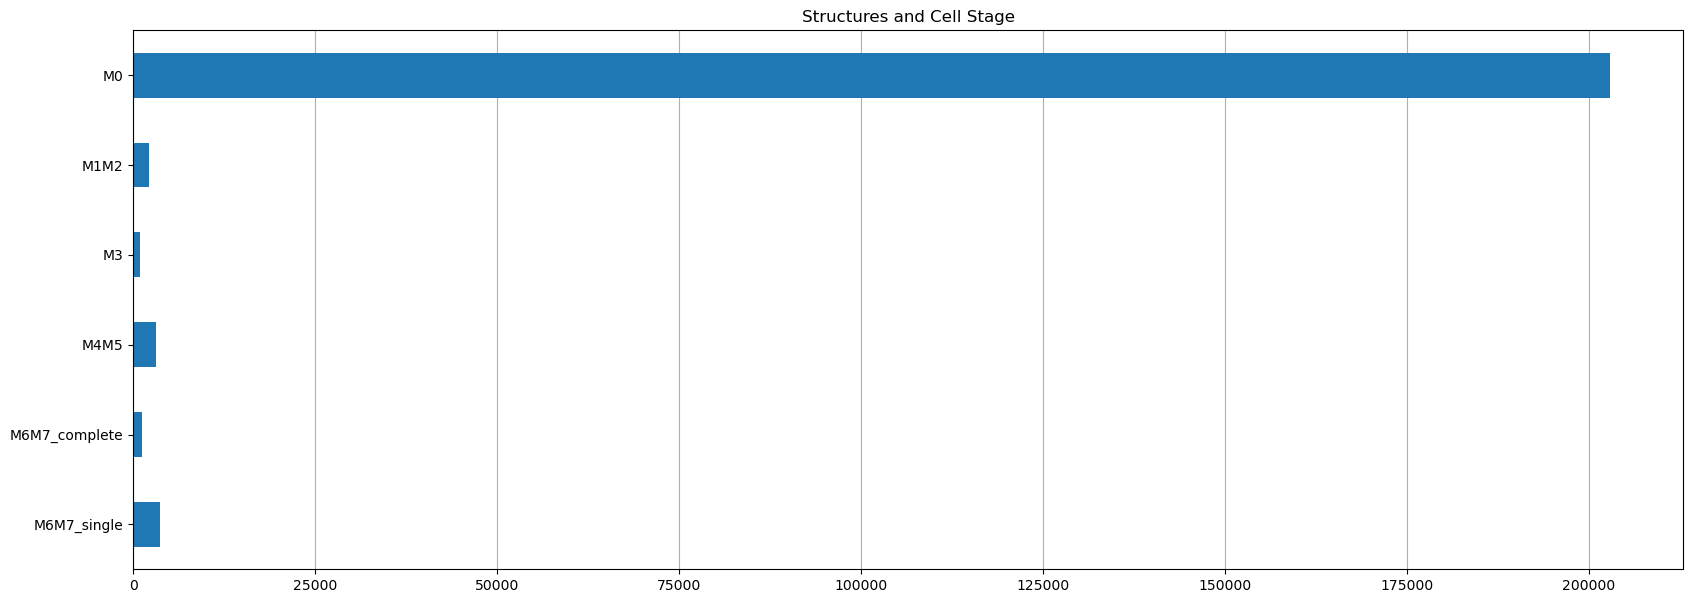

In [11]:
table = pd.pivot_table(df, index="cell_stage", aggfunc="size")
fig, axes = plt.subplots(figsize=(20, 7), dpi=100)
table.plot.barh(stacked=True, ax=axes)
axes.set_ylabel(None)
axes.set_title("Structures and Cell Stage")
axes.grid(True, which="major", axis="x")
axes.set_axisbelow(True)
axes.invert_yaxis()
plt.show()

In [7]:
df.columns

Index(['angle', 'bbox_max_x', 'bbox_max_y', 'bbox_max_z', 'bbox_min_x',
       'bbox_min_y', 'bbox_min_z', 'bf_clip_hi', 'bf_clip_lo', 'cell_stage',
       'CellId', 'Cellular Component', 'center_slice',
       'Description (from Uniprot)', 'dna_clip_hi', 'dna_clip_lo',
       'Draft mitotic state resolved', 'edge_flag', 'fits_x', 'fits_y',
       'fits_z', 'FOVId', 'InstrumentId', 'max_projection_x',
       'max_projection_y', 'max_projection_z', 'mean_projection_x',
       'mean_projection_y', 'mean_projection_z', 'median_projection_x',
       'median_projection_y', 'median_projection_z', 'cell_height',
       'cell_surface_area', 'cell_volume', 'membrane_clip_hi',
       'membrane_clip_lo', 'meta_colony_area', 'meta_colony_centroid',
       'meta_colony_label', 'meta_fov_edgedist', 'meta_fov_outside_overview',
       'meta_fov_position', 'meta_fov_xcoord', 'meta_fov_ycoord',
       'meta_imaging_mode', 'meta_plate_bad_segmentation',
       'meta_plate_confluency', 'meta_well_passage

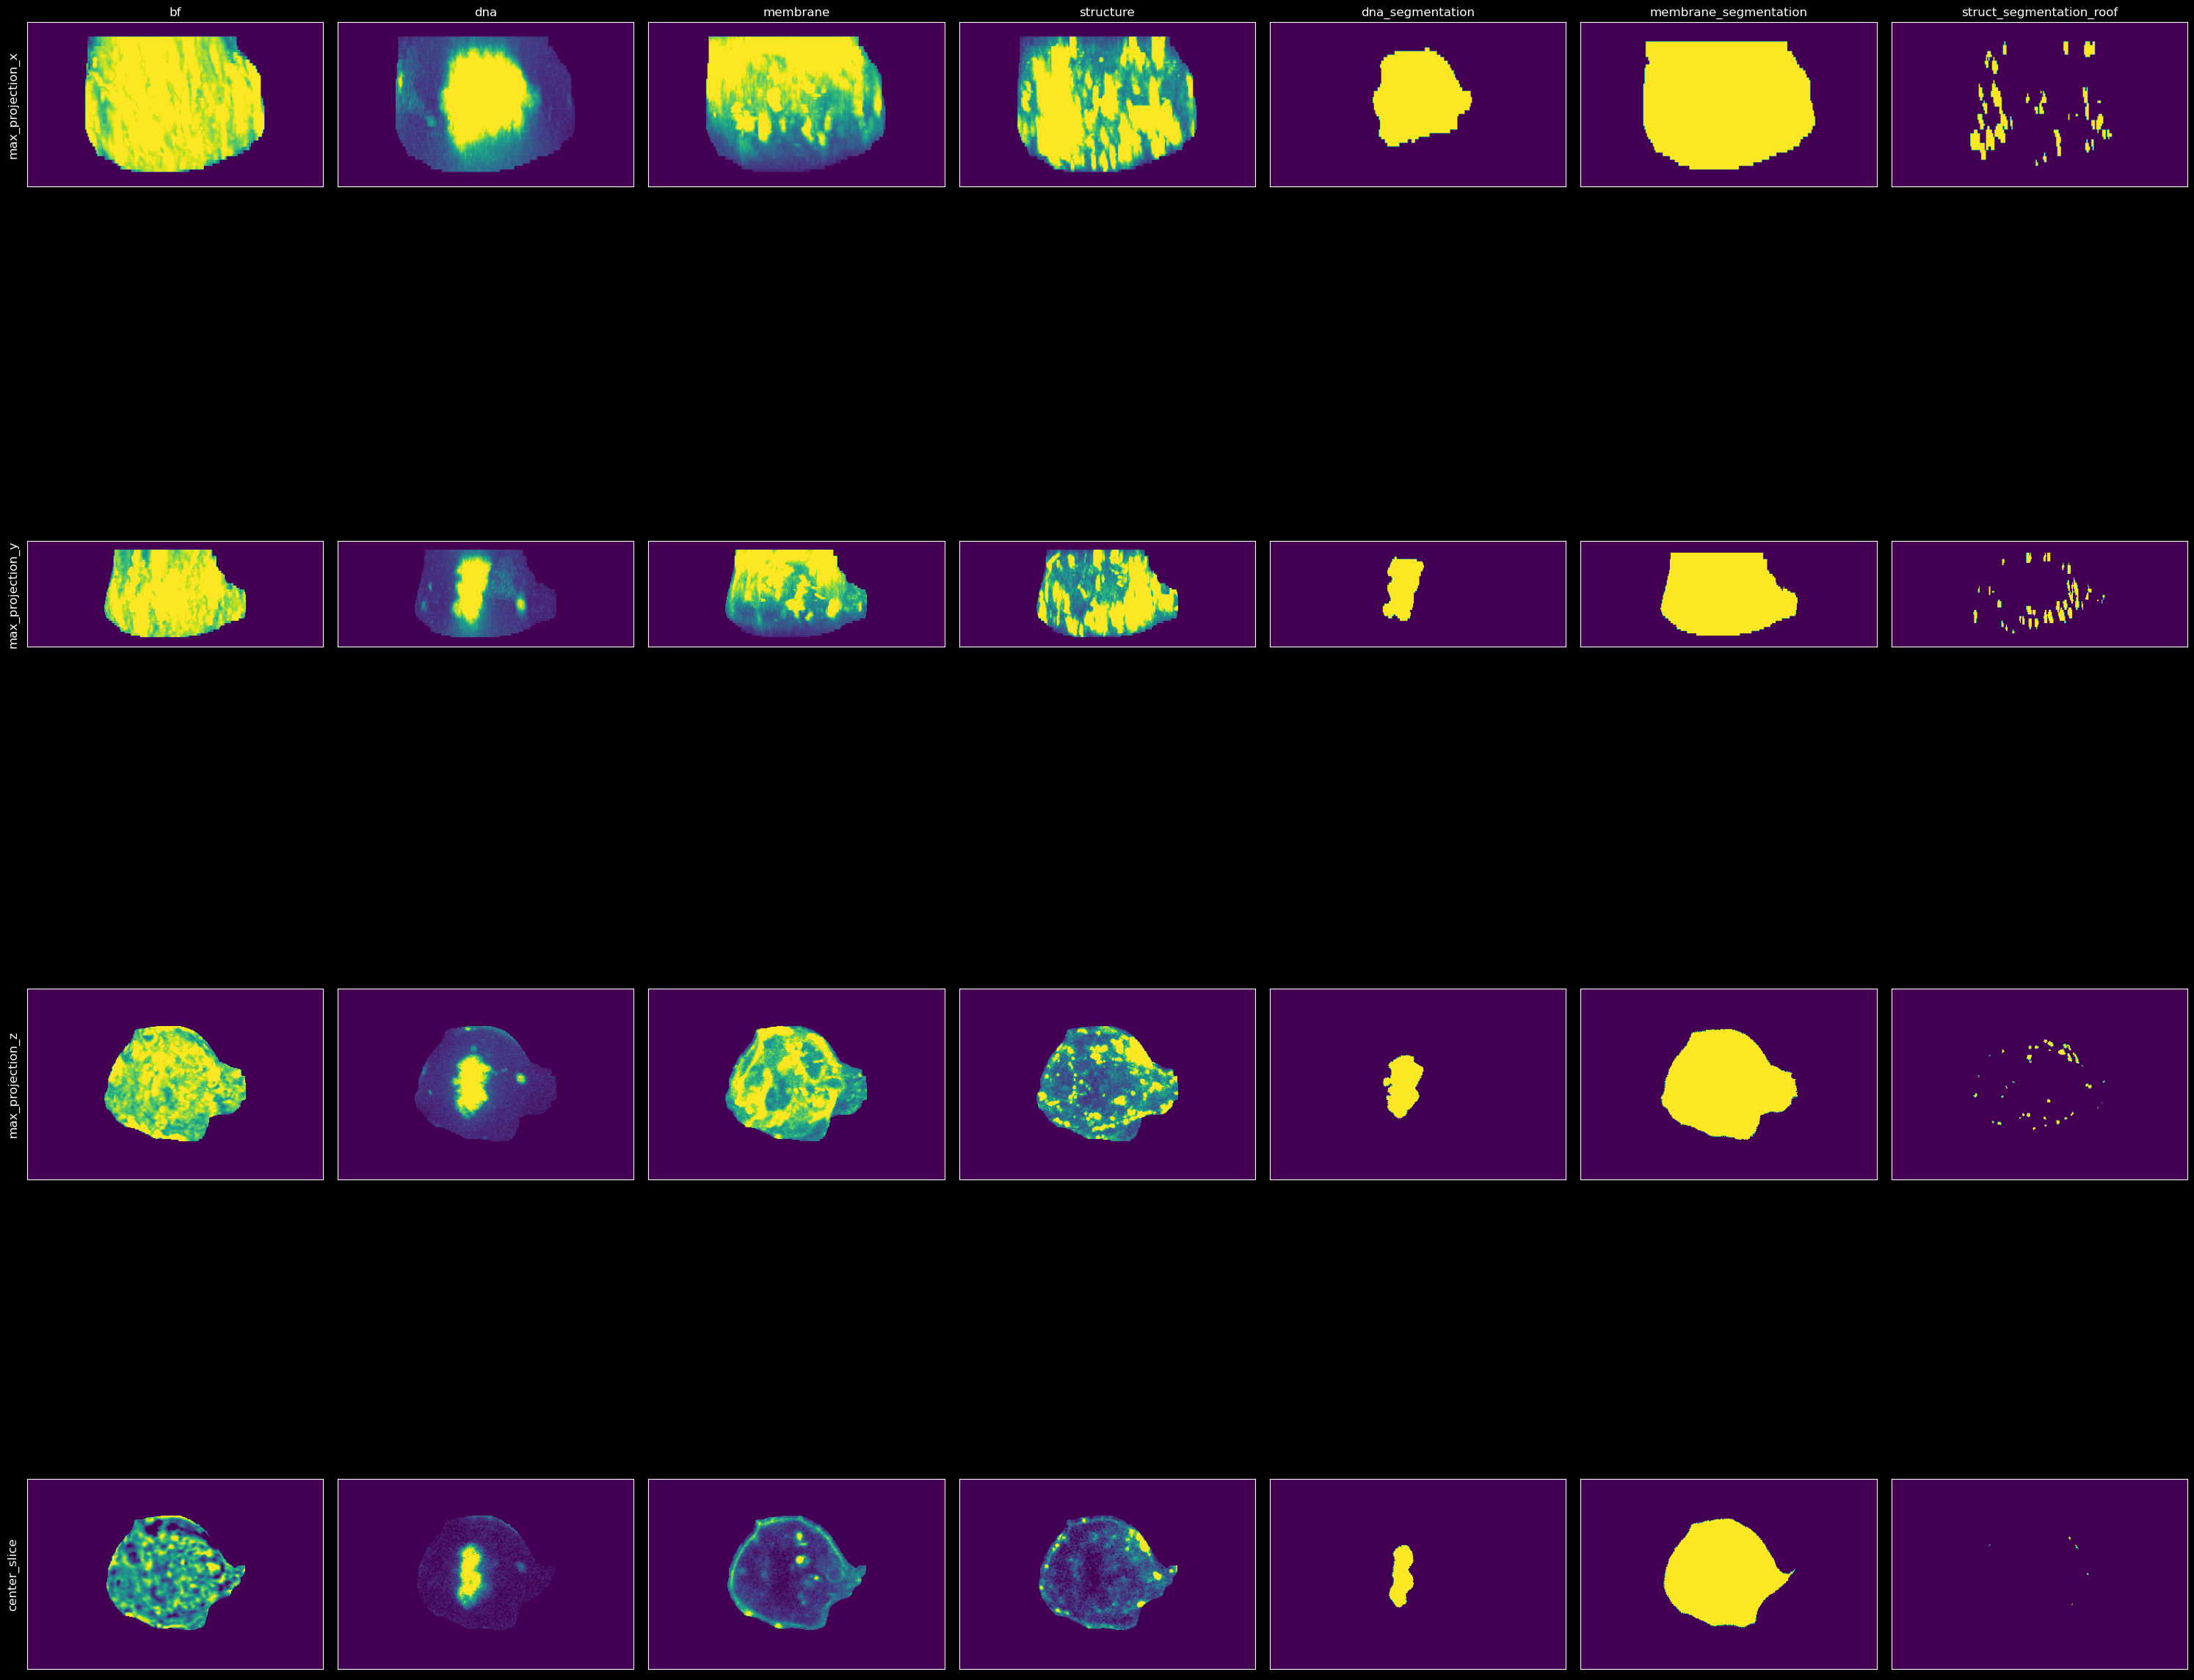

In [32]:
%matplotlib inline
some_cell =df[
    (df['cell_stage'] == "M6M7_single")
].sample(1).iloc[0]

full_img = read_ome_zarr(some_cell["registered_path"])

projections = [
    'max_projection_x',
    'max_projection_y',
    'max_projection_z',
    'center_slice'
]

f, axs = plt.subplots(len(projections), 7, figsize=(30, 30))
for proj_ix, projection in enumerate(projections):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        proj = AICSImage(some_cell[projection]).data.squeeze()
    
    for ix, channel in enumerate(full_img.channel_names):
        axs[proj_ix, ix].imshow(proj[ix])
        
        if proj_ix == 0:
            axs[proj_ix, ix].set_title(channel, size="large")
        axs[proj_ix, ix].set_xticks([])
        axs[proj_ix, ix].set_yticks([])


    axs[proj_ix, 0].set_ylabel(projection, rotation=90, size='large')

plt.tight_layout()
plt.show()